In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np


import tensorflow as tf


import os

# os.environ['PATH']='/opt/Xilinx/Vivado/2018.2/bin:' + os.environ['PATH']

In the context of jet tagging in high-energy physics experiments like those conducted at the Large Hadron Collider (LHC), the labels 'g', 'q', 't', 'w', and 'z' typically represent different types of jets or particles produced in collision events. Here's what each label commonly stands for:

- *'g'*: This typically represents gluon jets. Gluons are the force carriers of the strong nuclear force, which binds quarks together to form protons, neutrons, and other particles. Gluon jets are jets predominantly composed of gluons.

- *'q'*: This usually represents quark jets. Quarks are fundamental particles that combine to form composite particles like protons, neutrons, and mesons. Quark jets are jets predominantly composed of quarks.

- *'t'*: This often represents top quark jets. The top quark is the heaviest known elementary particle and plays a significant role in various processes studied at particle colliders like the LHC.

- *'w'*: This commonly represents jets originating from the decay of W bosons. W bosons are elementary particles that mediate the weak nuclear force, responsible for processes like beta decay and the decay of heavy particles.

- *'z'*: This typically represents jets originating from the decay of Z bosons. Z bosons are neutral elementary particles that also mediate the weak nuclear force, often involved in processes like neutrino interactions and other weak interactions.

In summary, these labels are used to classify jets based on the particles or processes from which they originate, providing valuable information for understanding the underlying physics of collision events in particle accelerators.

In [6]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

/home/tammireddy/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [9]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [10]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [13]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

In [17]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='keras_model',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('keras_model/KERAS_check_best_model.h5')

Epoch 1/30
478/487 [============================>.] - ETA: 0s - loss: 0.6776 - accuracy: 0.7678
***callbacks***
saving losses to keras_model/losses.log

Epoch 1: val_loss improved from inf to 0.68497, saving model to keras_model/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.68497, saving model to keras_model/KERAS_check_best_model_weights.h5

Epoch 1: saving model to keras_model/KERAS_check_model_last.h5

Epoch 1: saving model to keras_model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.6779 - accuracy: 0.7676 - val_loss: 0.6850 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 2/30
486/487 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.7674
***callbacks***
saving losses to keras_model/losses.log

Epoch 2: val_loss improved from 0.68497 to 0.68455, saving model to keras_model/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.68497 to 0.68455, saving model to kera

466/487 [===========================>..] - ETA: 0s - loss: 0.6756 - accuracy: 0.7678
***callbacks***
saving losses to keras_model/losses.log

Epoch 14: val_loss did not improve from 0.68132

Epoch 14: val_loss did not improve from 0.68132

Epoch 14: saving model to keras_model/KERAS_check_model_last.h5

Epoch 14: saving model to keras_model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.6753 - accuracy: 0.7680 - val_loss: 0.6841 - val_accuracy: 0.7660 - lr: 0.0010
Epoch 15/30
469/487 [===========================>..] - ETA: 0s - loss: 0.6749 - accuracy: 0.7682
***callbacks***
saving losses to keras_model/losses.log

Epoch 15: val_loss did not improve from 0.68132

Epoch 15: val_loss did not improve from 0.68132

Epoch 15: saving model to keras_model/KERAS_check_model_last.h5

Epoch 15: saving model to keras_model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 

Epoch 28/30
471/487 [============================>.] - ETA: 0s - loss: 0.6730 - accuracy: 0.7683
***callbacks***
saving losses to keras_model/losses.log

Epoch 28: val_loss did not improve from 0.67975

Epoch 28: val_loss did not improve from 0.67975

Epoch 28: saving model to keras_model/KERAS_check_model_last.h5

Epoch 28: saving model to keras_model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.6734 - accuracy: 0.7682 - val_loss: 0.6799 - val_accuracy: 0.7664 - lr: 0.0010
Epoch 29/30
469/487 [===========================>..] - ETA: 0s - loss: 0.6737 - accuracy: 0.7684
***callbacks***
saving losses to keras_model/losses.log

Epoch 29: val_loss did not improve from 0.67975

Epoch 29: val_loss did not improve from 0.67975

Epoch 29: saving model to keras_model/KERAS_check_model_last.h5

Epoch 29: saving model to keras_model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [=========================

5188/5188 [==============================] - 3s 599us/step
Accuracy: 0.765722891566265


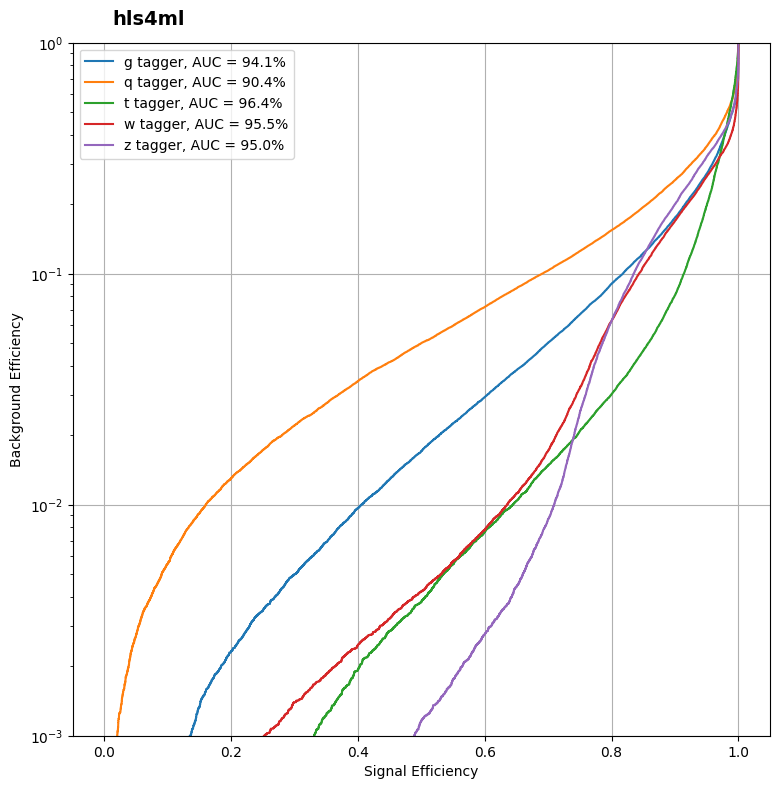

In [19]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

In [ ]:
model.save('jet_tagging_classifier')